# Lab 03: Introduction of Digital Data Acquisition, FFT, and Spectrum Analysis 2

### MAE 3120, Spring 2022

**Caden Gobat & Jade Greenberg**

## Setup

### Import required packages

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import interpolate, signal

### Traverse filetree and compile list of data filepaths/names

In [2]:
for (root, dirs, files) in os.walk("../Lab02_DataAcquisitionFFT1/"):
    lab2files = ["../Lab02_DataAcquisitionFFT1/"+fn for fn in files if fn[-3:]=="csv"]

for (root, dirs, files) in os.walk("./"):
    lab3files = ["../Lab03_DataAcquisitionFFT2/"+fn for fn in files if fn[-3:]=="csv"]

data_files = lab2files + lab3files
data_files.sort()

### Define helper functions

These are custom-written functions to facilitate our work here. Docstrings have individual documentation.

In [3]:
def read_data(fn,metadata=False):
    """
    Read in a .csv file of time-series data collected using NI 9201 DAQ module.
    Optionally return the metadata included in the header of the file.
    """
    df = pd.read_csv(fn,header=3)
    df.columns = ["t","V"]
    if metadata:
        with open(fn,"r") as f:
            (timestamp, sample_info, DAQ_info) = f.readlines()[:3]
        header_info = "".join([timestamp, sample_info, DAQ_info])
        return df,header_info
    else:
        return df

def fft(t, signal):
    """
    Compute the fast Fourier transform of time-series data.
    Scale the spectrum and frequency space appropriately.
    """
    d = np.diff(t).mean()
    N = len(signal)
    sp = np.abs(np.fft.fft(signal))*2/N
    frq = np.fft.fftfreq(N,d)
    return frq[:N//2], sp[:N//2]

def fft_plot(t, signal, ax=None, logf=False, **kwargs):
    "Plot the FFT spectrum computed using fft() function above"
    f, sp = fft(t,signal)
    if ax:
        ax.stem(f, sp, linefmt='k-', markerfmt=".", basefmt="none", label='Frequency', **kwargs)
        ax.set_ylim(0,)
        # ax.set_xlim(0,)
        if logf:
            ax.set_xscale("log")
    else:
        plt.stem(f, sp, linefmt='k-', markerfmt=".", basefmt="none", label='Frequency', **kwargs)
        # plt.xlim(0,f.max())
        plt.ylim(0,)
        if logf:
            plt.xscale("log")

signal_model = lambda t,f,DCO=0 : np.cos(2*np.pi*f*t)+DCO

def han_window(t,signal):
    "Apply Hanning windowing function and return modified signal"
    T = t.max()-t.min()
    window = (1-np.cos(2*np.pi*t/T))/2
    return window*signal

def spectral_amp(t,y,f,FWHM=False,tol=2):
    """
    Compute the Fourier coefficient value at a certain frequency
        (or as close as possible on the spectrum)

    Inputs:
        t : array-like
            independent variable of signal
        y : array-like
            dependent variable of signal
        f : numeric
            target frequency at which to evaluate spectral amplitude
        FWHM : boolean
            whether to return peak width as well
        tol : integer
            number of indices to search on either side of the point closest to f

    Outputs:
        if FWHM :
            tuple of (coefficient value,FWHM)
        else :
            coefficient value
    """
    fspace,sp = fft(t,y)
    df = np.diff(fspace).mean()
    X = interpolate.interp1d(fspace,sp)
    coeff = X(f)
    if FWHM:
        f_idx = np.argmin(np.abs(fspace-f))
        w,wh,L,R = signal.peak_widths(sp.flatten(),[f_idx])
        fwhm = w*df
        return 2*wh[0],fwhm[0]
    else:
        return coeff

## Part I: Discrete Data Acquisition

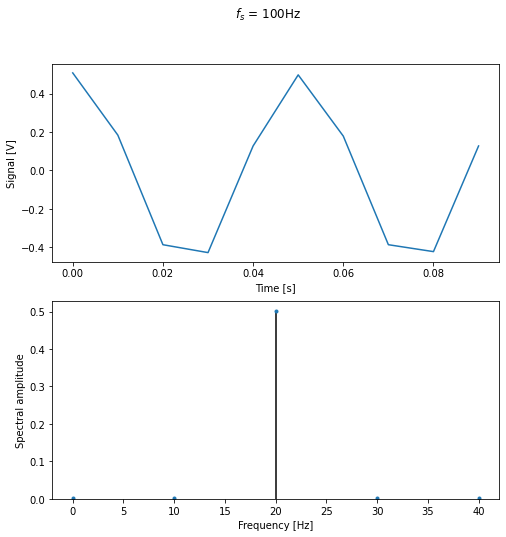

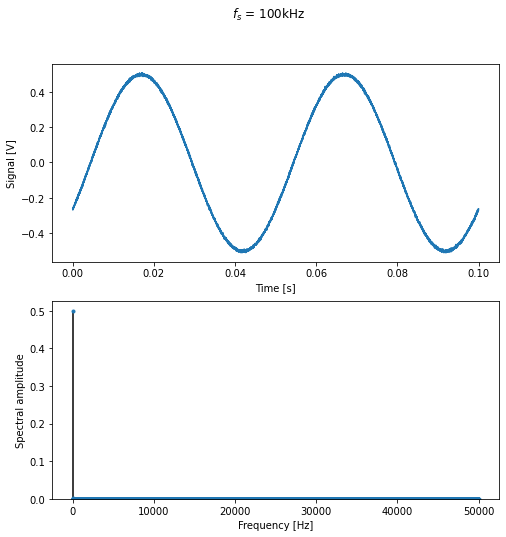

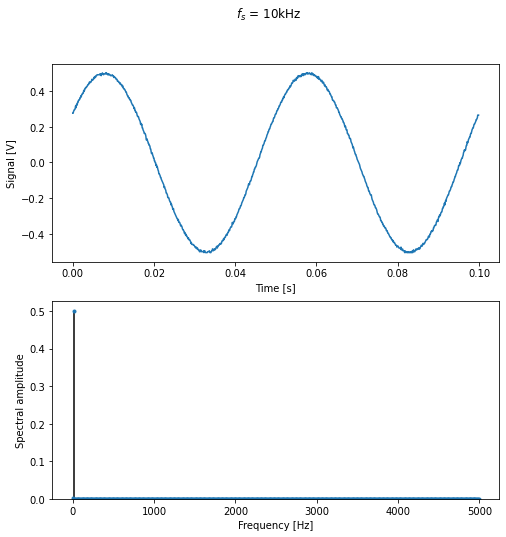

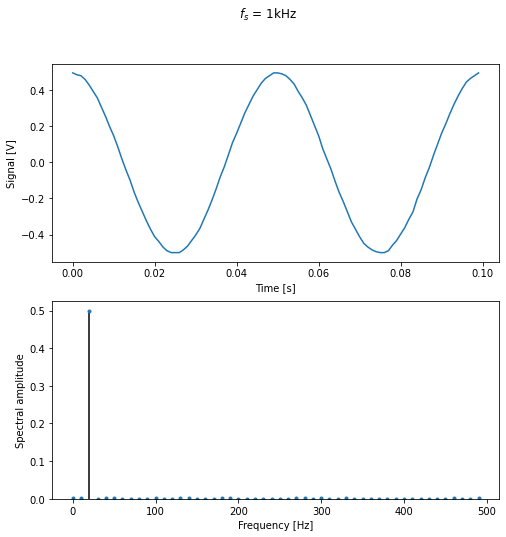

In [4]:
for fn in data_files:
    if "PtIV-" in fn:
        data = read_data(fn)
        fig,ax = plt.subplots(2,1,figsize=(8,8)) # two subplots stacked vertically
        ax[0].plot(data.t,data.V)
        ax[0].set_xlabel("Time [s]")
        ax[0].set_ylabel("Signal [V]")
        fft_plot(data["t"],data["V"],ax=ax[1])
        ax[1].set_xlabel("Frequency [Hz]")
        ax[1].set_ylabel("Spectral amplitude")
        fig.suptitle("$f_s$ = "+fn[34:-4])
        plt.show()

## Part II: Leakage effect

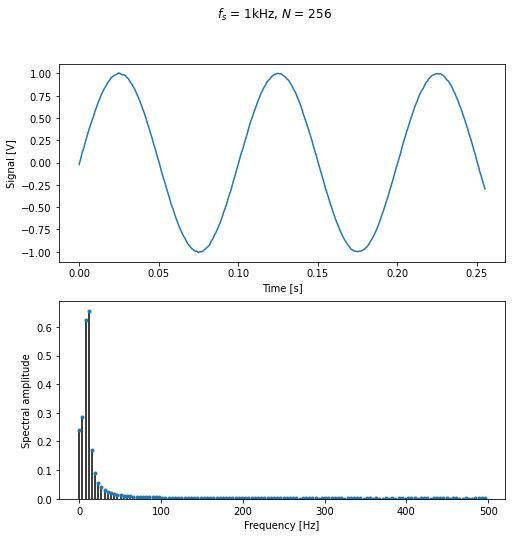

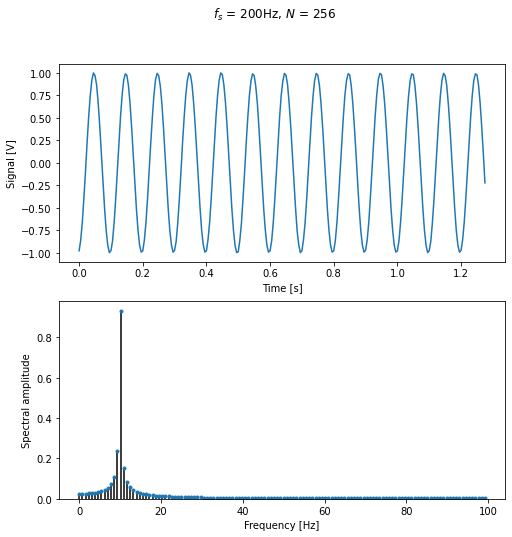

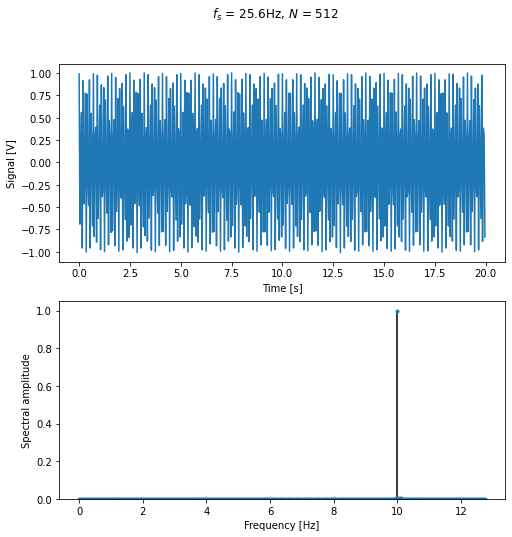

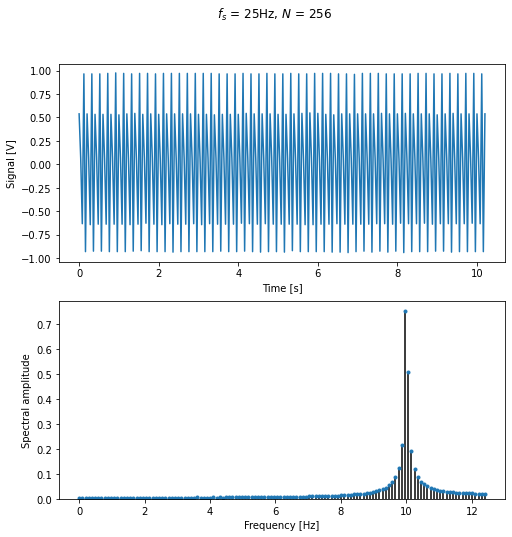

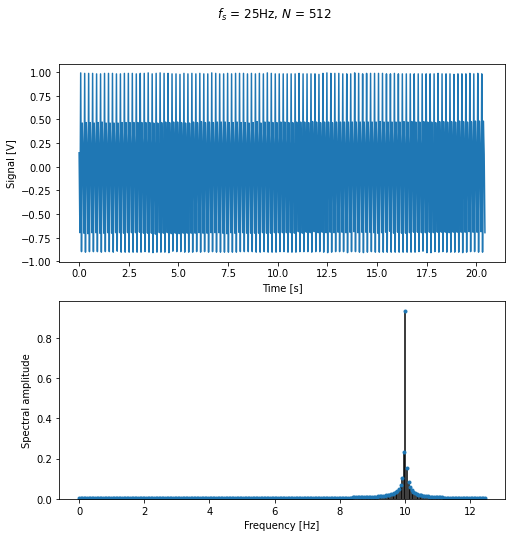

In [5]:
for fn in data_files:
    if "/PtV-" in fn: # Part II of this lab was Part V of the last lab
        part,fs,points = fn.split("-") # according to our naming convention
        data = read_data(fn)
        fig,ax = plt.subplots(2,1,figsize=(8,8)) # two subplots stacked vertically
        ax[0].plot(data.t,data.V)
        ax[0].set_xlabel("Time [s]")
        ax[0].set_ylabel("Signal [V]")
        fft_plot(data["t"],data["V"],ax=ax[1])
        ax[1].set_xlabel("Frequency [Hz]")
        ax[1].set_ylabel("Spectral amplitude")
        fig.suptitle(f"$f_s$ = {fs}, $N$ = {points[:-4]}")
        plt.show()

## Part III: Windowing of FFT

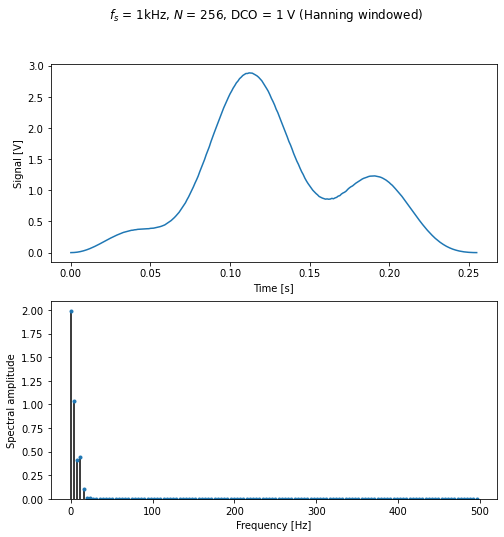

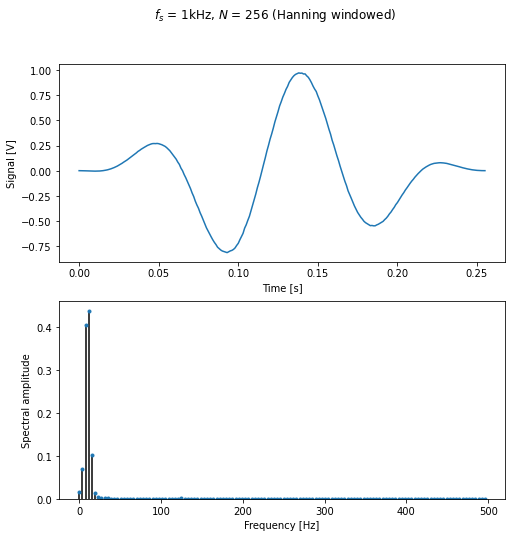

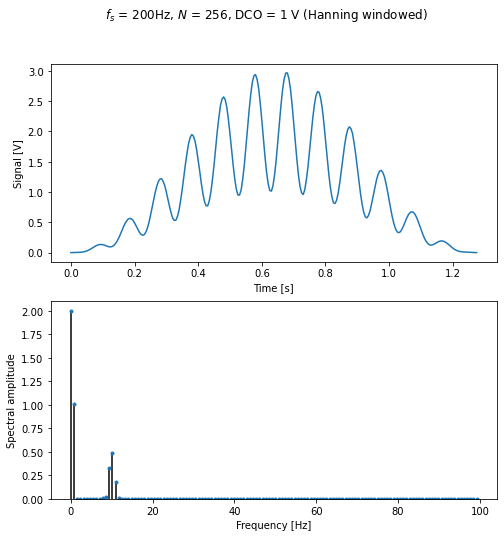

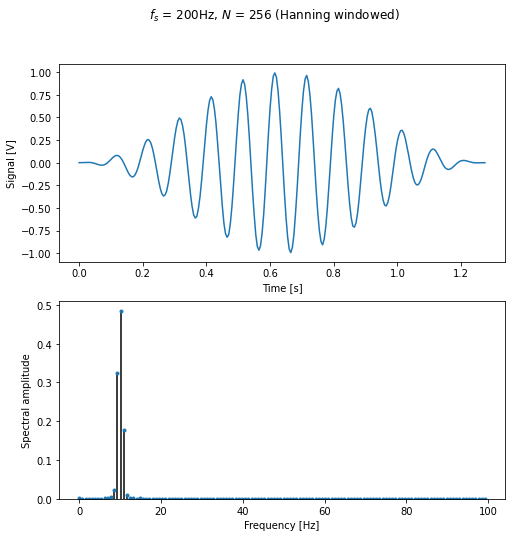

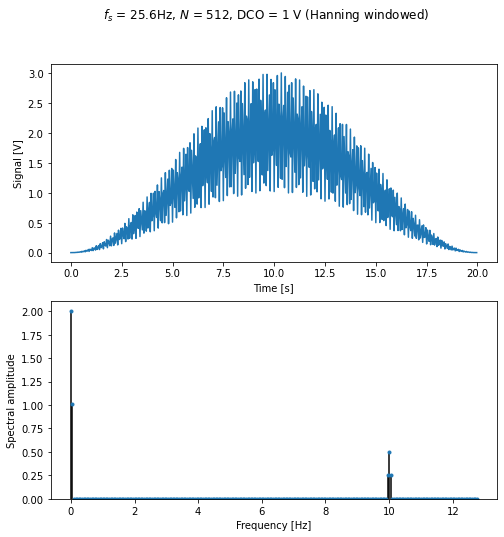

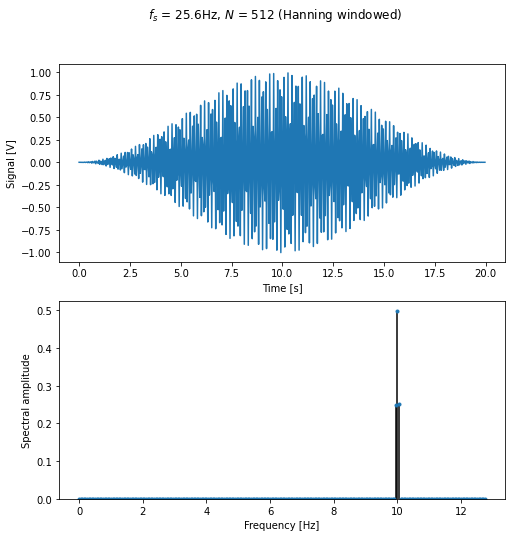

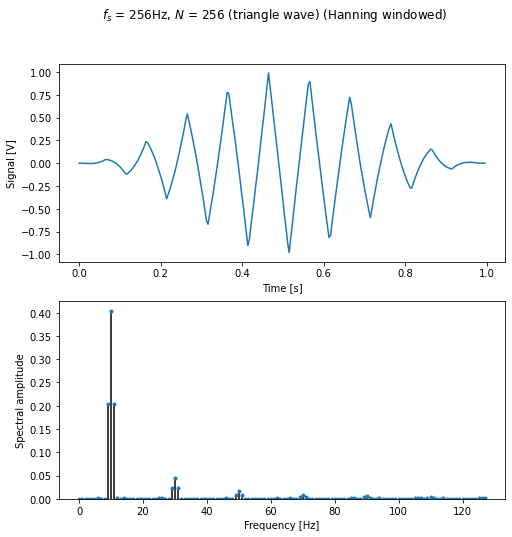

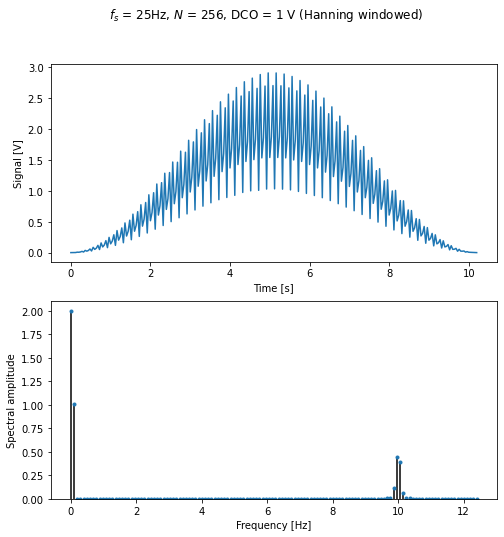

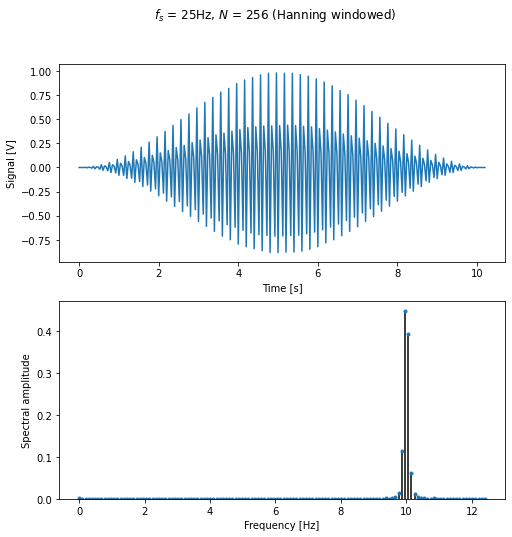

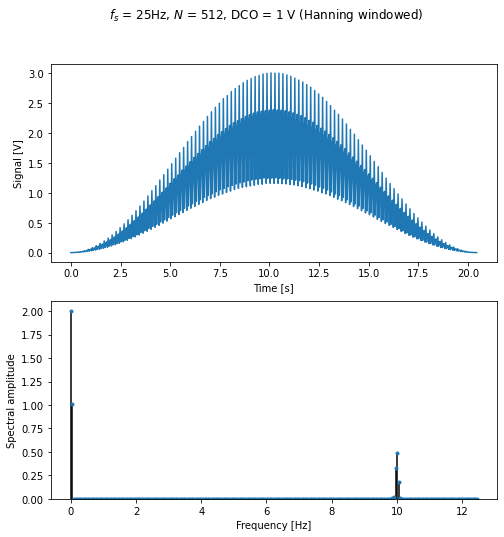

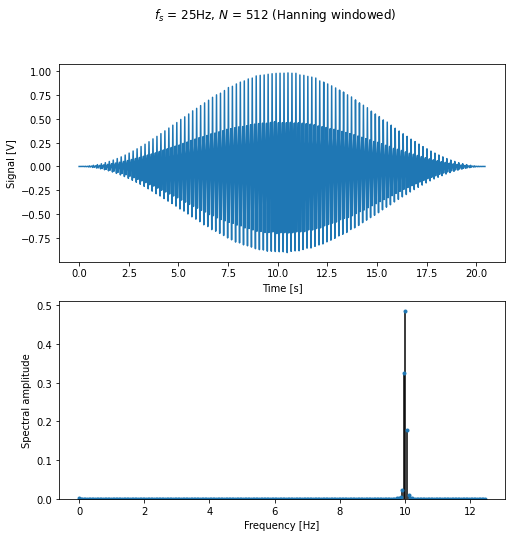

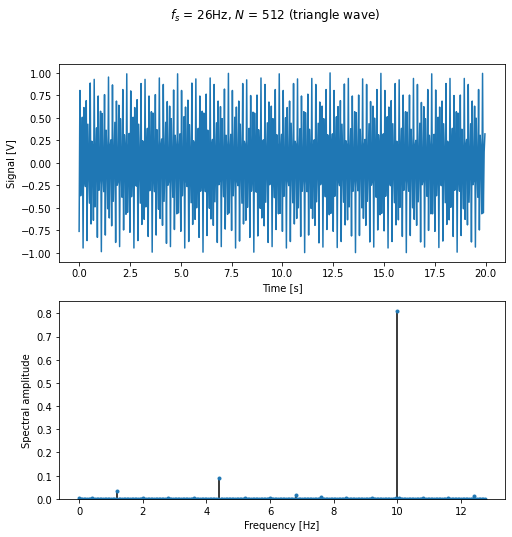

In [6]:
for fn in data_files:
    if ("PtVI-" in fn):
        meta = fn.split("-")
        if len(meta)==3:
            part,fs,points = meta
            points = points[:-4]
            dco = False
        elif len(meta)==4:
            part,fs,points,dco = meta
        else:
            print(meta)
        data = read_data(fn)
        fig,ax = plt.subplots(2,1,figsize=(8,8)) # two subplots stacked vertically
        if "nowindow" not in fn: # apply Hanning window to applicable data
            data.V = han_window(data.t,data.V)
            windowed = True
        else:
            windowed = False
        ax[0].plot(data.t,data.V)
        ax[0].set_xlabel("Time [s]")
        ax[0].set_ylabel("Signal [V]")
        fft_plot(data["t"],data["V"],ax=ax[1])
        ax[1].set_xlabel("Frequency [Hz]")
        ax[1].set_ylabel("Spectral amplitude")
        titlestr = f"$f_s$ = {fs}, $N$ = {points}"
        if dco:
            if "DCO" in dco:
                titlestr += ", DCO = 1 V"
            elif "triangle" in dco:
                titlestr += " (triangle wave)"
        if windowed:
            titlestr += " (Hanning windowed)"
        fig.suptitle(titlestr)
        plt.show()

Applying the Hanning window function creates additional low-frequency harmonic components in the spectrum, which makes sense. We do not note much noticeable improvement in the definition of the spectral peaks at the frequencies we expect them to be.

With a DC offset, the Hanning function makes it so that the signal is no longer centered around its mean (i.e. the whole thing increases and then comes back down over the course of the sample window).

The triangle wave is a periodic function made up of several harmonics with decreasing intensity amplitudes. This makes sense based on what we know about the analytical Fourier series concept.

## Part IV: Clipping

# fs = 10000 Hz, N = 1000


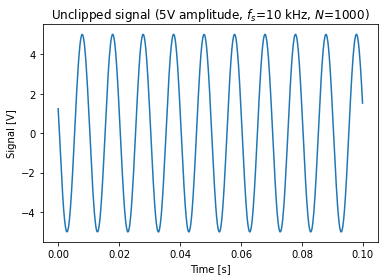

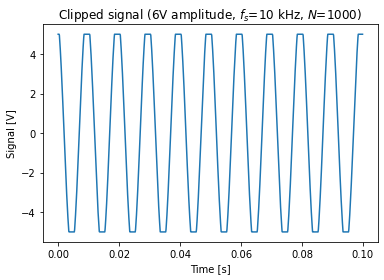

In [19]:
unclipped = read_data("./Lab03_PtIV.csv")
print(info.split("\n")[1])
plt.plot(unclipped["t"],unclipped["V"])
plt.xlabel("Time [s]")
plt.ylabel("Signal [V]")
plt.title("Unclipped signal (5V amplitude, $f_s$=10 kHz, $N$=1000)")
plt.show()

clipped = read_data("./Lab03_PtIV_clipped.csv")
clipped["V"] -= 5
clipped["V"] *= 1.2
clipped.loc[clipped["V"]>5,"V"] = 5
clipped.loc[clipped["V"]<-5,"V"] = -5
plt.plot(clipped["t"],clipped["V"])
plt.xlabel("Time [s]")
plt.ylabel("Signal [V]")
plt.title("Clipped signal (6V amplitude, $f_s$=10 kHz, $N$=1000)")
plt.show()

## Part V: Signal reconstruction

5 V amplitude 10 Hz carrier wave w/ 1 V amplitude 3.1 kHz noise.

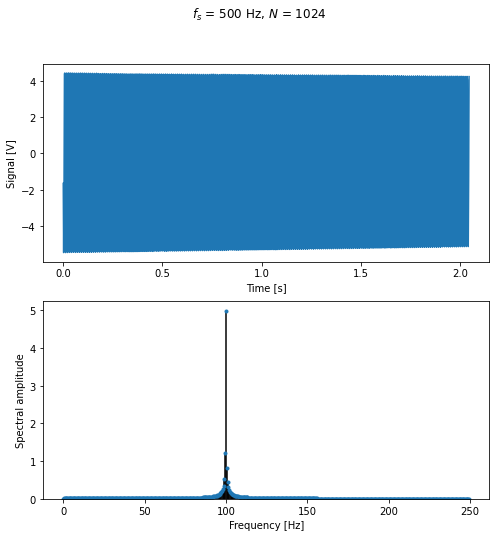

For 1024 data points sampled at 500 Hz, spectral resolution is Δf=0.488 Hz (i.e. 2.048 frequency samples/Hz)


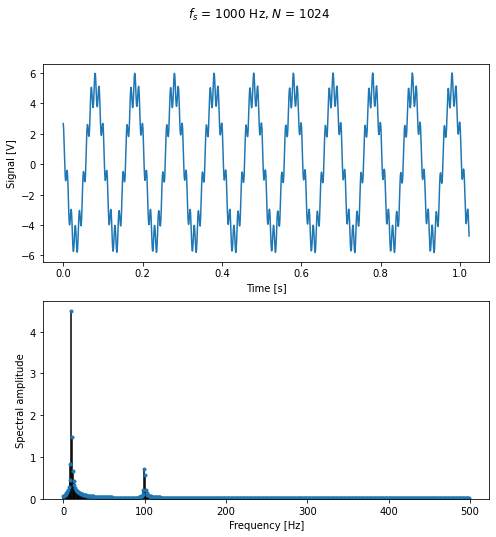

For 1024 data points sampled at 1000 Hz, spectral resolution is Δf=0.977 Hz (i.e. 1.024 frequency samples/Hz)


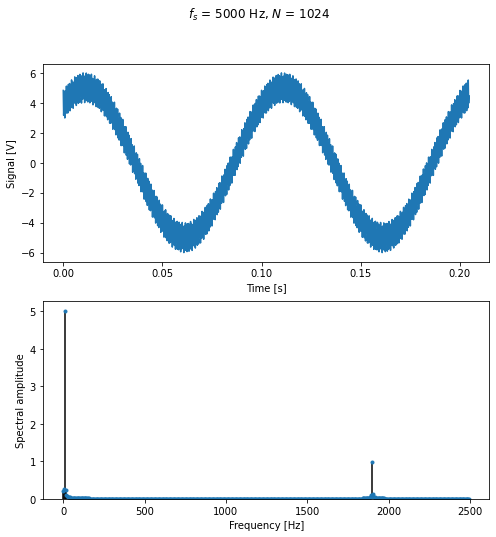

For 1024 data points sampled at 5000 Hz, spectral resolution is Δf=4.883 Hz (i.e. 0.2048 frequency samples/Hz)


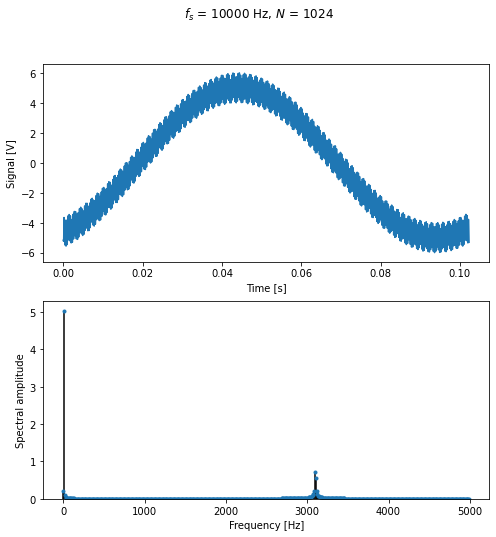

For 1024 data points sampled at 10000 Hz, spectral resolution is Δf=9.766 Hz (i.e. 0.1024 frequency samples/Hz)


In [33]:
fs = {"a":500,"b":1000,"c":5000,"d":10000}
N = 1024

for letter in "abcd":
    fn = f"./Lab03_PtV{letter}.csv"
    data,info = read_data(fn,metadata=True)
    fig,ax = plt.subplots(2,1,figsize=(8,8)) # two subplots stacked vertically
    ax[0].plot(data.t,data.V)
    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Signal [V]")
    fft_plot(data["t"],data["V"],ax=ax[1])
    ax[1].set_xlabel("Frequency [Hz]")
    ax[1].set_ylabel("Spectral amplitude")
    fig.suptitle(f"$f_s$ = {fs[letter]} Hz, $N$ = {N}")
    plt.show()
    print(f'For {N} data points sampled at {fs[letter]} Hz, spectral resolution is Δf={fs[letter]/N:.3f} Hz (i.e. {N/fs[letter]} frequency samples/Hz)')


To acquire the signal without aliasing, we need $f_s > 6.2\text{ kHz}$. We observe this in the final trial where $f_s=10\text{ kHz}$, both frequency components appear as expected with appropriate amplitudes.

## Discussion questions

1) Explain why you need to select the output of your waveform generator to infinite impedance. What would happen if you had it selected for 50 Ω impedance?
> We set the output impedance to $\infty$ in order to ensure that the signal being created matches the display and the settings. Changing it to a finite value like $50\ \Omega$ would cause the observed amplitude of the signal to differ from the $V_\text{pp}$ set on the waveform generator.


2) Part II, for each of the test cases, calculate the frequency resolution and the energy contained at the signal frequency (10 Hz). Comment on:
    
    A. The resolution of the sine wave.
    
    B. The width of the spike on the frequency spectrum and the energy contained at 10 Hz vs what you would expect. Explain how the width changes for each condition and what is the source of the observed phenomenon and how it can be corrected.

In [7]:
for fn in data_files:
    if "/PtV-" in fn: # Part II of this lab was Part V of the last lab
        part,fs,points = fn.split("-") # according to our naming convention
        points = int(points[:-4])
        fs = fs.replace("Hz","")
        fs = fs.replace("k","000")
        fs = float(fs)
        data = read_data(fn)
        T = data["t"].max()-data["t"].min()
        A_10,w_10 = spectral_amp(data.t,data.V,10,FWHM=True)
        print(fn[3:-4])
        print(f'Sample window: {T:.3f} sec ({T*10} cycles)')
        print(f'Δt: {np.diff(data.t).mean():.3f} sec (f_s = {fs} samples/sec)')
        print(f'Δf: {fs/points:.3f} Hz (i.e. {points/fs} samples/Hz)')
        print(f'Spectral energy Ψ(10 Hz): {A_10**2:.3f}')
        print(f'FWHM @ 10 Hz (orig): {w_10:.4f} Hz (={w_10/(fs/points):.2f}Δf)')
        data_window = han_window(data.t,data.V)
        A_10,w_10 = spectral_amp(data.t,data_window,10,FWHM=True)
        print(f'FWHM @ 10 Hz (windowed): {w_10:.4f} Hz\n')

Lab02_DataAcquisitionFFT1/PtV-1kHz-256
Sample window: 0.255 sec (2.55 cycles)
Δt: 0.001 sec (f_s = 1000.0 samples/sec)
Δf: 3.906 Hz (i.e. 0.256 samples/Hz)
Spectral energy Ψ(10 Hz): 0.805
FWHM @ 10 Hz (orig): 7.6230 Hz (=1.95Δf)
FWHM @ 10 Hz (windowed): 8.3458 Hz

Lab02_DataAcquisitionFFT1/PtV-200Hz-256
Sample window: 1.275 sec (12.75 cycles)
Δt: 0.005 sec (f_s = 200.0 samples/sec)
Δf: 0.781 Hz (i.e. 1.28 samples/Hz)
Spectral energy Ψ(10 Hz): 0.913
FWHM @ 10 Hz (orig): 0.9666 Hz (=1.24Δf)
FWHM @ 10 Hz (windowed): 1.6109 Hz

Lab02_DataAcquisitionFFT1/PtV-25.6Hz-512
Sample window: 19.961 sec (199.609375 cycles)
Δt: 0.039 sec (f_s = 25.6 samples/sec)
Δf: 0.050 Hz (i.e. 20.0 samples/Hz)
Spectral energy Ψ(10 Hz): 1.001
FWHM @ 10 Hz (orig): 0.0501 Hz (=1.00Δf)
FWHM @ 10 Hz (windowed): 0.1002 Hz

Lab02_DataAcquisitionFFT1/PtV-25Hz-256
Sample window: 10.200 sec (102.0 cycles)
Δt: 0.040 sec (f_s = 25.0 samples/sec)
Δf: 0.098 Hz (i.e. 10.24 samples/Hz)
Spectral energy Ψ(10 Hz): 0.599
FWHM @ 10 H

> Spectral leakage occurs when the signal frequency does not appear exactly in the frequency space of the FFT. In an ideal spectrum, we should expect the FWHM of the spectral peak at $f=10\text{ Hz}$ to be approximately $\Delta f$, since the peak should theoretically be contained in a single frequency bin. We see that this is the case for the "perfect" FFT ($f_s=25.6\text{ Hz}$, $N=512$), but that we have leakage in all other cases, since the peak (FWHM) is notably wider than the bin resolution.

3) Part II conclusions:
    
    A. What is the benefit and drawbacks of increasing the sampling frequency?
    > Higher sampling frequency allows you to capture higher-frequency signal components without aliasing. The downside is that for a set number of points $N$, the higher the $f_s$, the fewer total periods of the waveform you capture.
    B. What is the benefit and drawbacks of increasing the sampling period?
    > Increasing the sampling period allows you to capture more of the waveform (e.g. for a 10 Hz signal, we need to sample for at least 0.1 seconds in order to capture a single period), but reduces resolution if the sampling frequency $f_s$ is not also changed.
    C. What is a “perfect FFT”?
    > A perfect FFT is one where $N$ is an integer multiple of $2f_s$ (and of course where $f_s$ is sufficiently high to satisfy the Nyquist condition for the highest-frequency component of the signal being measured).

4) What is the effect of the Hanning windowing on your signal? Does it totally eliminate leakage?
> Applying the Hanning window does not lead to much noticeable/considerable improvement as far as leakage goes. As shown in question 2), the peak width is actually larger in most cases for the windowed version of the signal, implying a greater degree of leakage.

5) What is the effect of windowing when there is a DC offset in addition of the sinusoidal signal? What can you conclude about the mean of a signal on which windowing can be applied? Propose a procedure to apply windowing when the signal has non-zero mean.
> Windowing a signal with a DC offset creates an additional artificial low frequency comoponent of $\frac{1}{2T}\text{ Hz}$, where $T$ is the sampling window. To correct this, we should subtract the signal mean from the signal *before* applying the windowing filter.

6) Which statistical tool/graph could you use to identify if some clipping took place in your data? What would you expect to see?
> A histogram would work for this purpose. If there is clipping in the data, then we would expect to see disproportionately many counts in the bins at the maximum and minimum of the range.

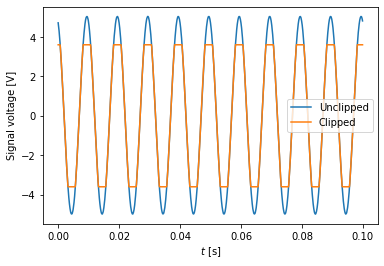

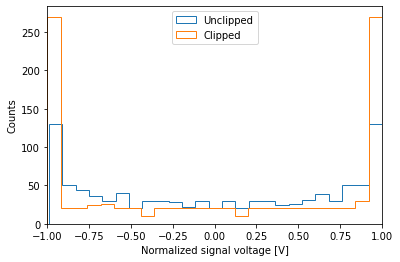

In [34]:
data = read_data("./Lab03_PtIV_clipped.csv")
data["V"] = (data["V"]-5)
data["V_c"] = data["V"].copy()
data.loc[data["V_c"]>3.6,"V_c"] = 3.6
data.loc[data["V_c"]<-3.6,"V_c"] = -3.6

plt.plot(data["t"],data["V"],label="Unclipped")
plt.plot(data["t"],data["V_c"],label="Clipped")
plt.xlabel("$t$ [s]")
plt.ylabel("Signal voltage [V]")
plt.legend()
plt.show()

plt.hist(data["V"]/data["V"].max(),25,histtype="step",label="Unclipped")
plt.hist(data["V_c"]/data["V_c"].max(),25,histtype="step",label="Clipped")
plt.legend(loc="upper center")
plt.xlim(-1,1)
plt.xlabel("Normalized signal voltage [V]")
plt.ylabel("Counts")
plt.show()

7) For Part V:

A. Which frequency was the optimum to record your signal? Hint: think about the frequency resolution.
    
> The ideal sampling frequency is one that gives rise to a frequency resolution such that the target frequencies appear exactly in the FFT frequency space.

B. Can you think a way to acquire the signal without aliasing?

> To prevent aliasing, we need only ensure that we satisfy the Nyquist criterion, which tells us we must sample at >2$\times$ the highest frequency we want to be able to observe without aliasing.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=385eace9-e066-4866-bb55-3a1ff5bdb476' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>